# **Importación de las paqueterias**

In [1]:
import pandas as pd
import numpy as np

from Machine_Learning_Tools.Neural_Networks_Models import cross_val_metrics,multi_layer_perceptron,single_layer_perceptron
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from Machine_Learning_Tools.plots import correlogram, pairplot
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook',style='whitegrid',palette='autumn',font_scale=1.5)
%matplotlib inline

# **Carga y exploración de los datos**

In [2]:
train = pd.read_csv('datasets/Mobile_Price/train.csv')

test = pd.read_csv('datasets/Mobile_Price/test.csv')

In [3]:
train.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

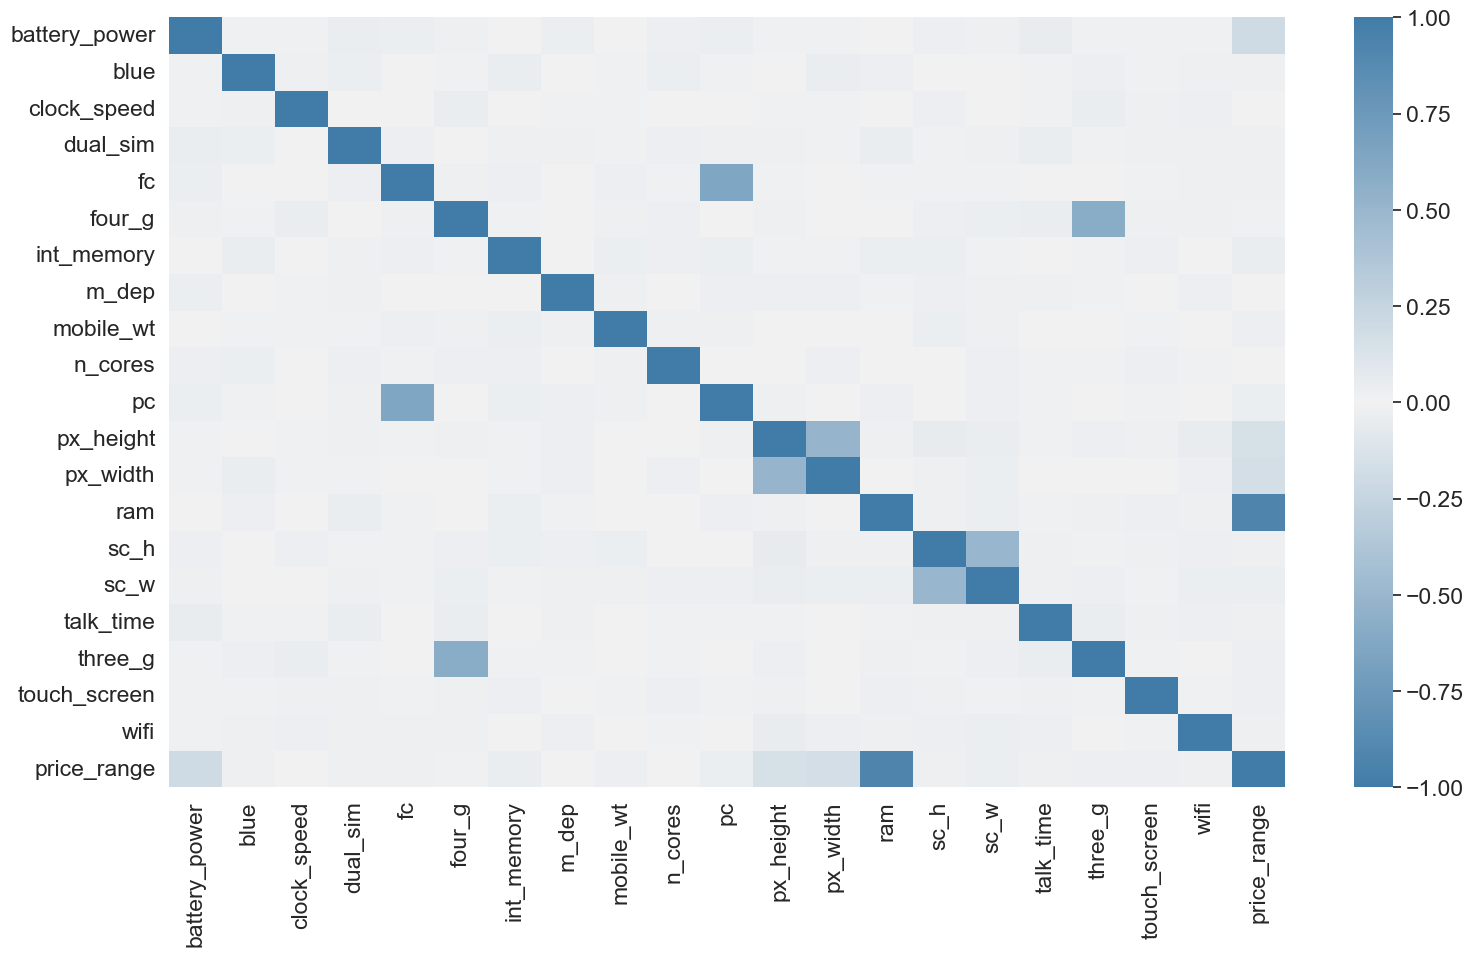

In [5]:
cols = list(train.columns)
correlogram(train, col = cols,figsize=(18,10))

# **Preprocesamiento de los datos**

## Definición de las variables explicativas y de la variable respuesta, además de los conjuntos de entrenamiento y prueba 

In [6]:
features = cols[:-1]
target = [cols[-1]]

train_size = round(0.8*train.shape[0])

train = train.sample(n=train.shape[0],random_state=100)

X_train = train[features].iloc[:train_size,:]

y_train = train[target].iloc[:train_size]

X_val = train[features].iloc[train_size:,:]

y_val = train[target].iloc[train_size:]


## Escalamiento de las variables explicativas

In [7]:
features_scaler = MinMaxScaler()
features_scaler.fit(X_train)

X_train_scaled = features_scaler.transform(X_train)
X_val_scaled = features_scaler.transform(X_val)

y_train_ohe = pd.get_dummies(y_train,dtype=float,columns=target).values
y_val_ohe = pd.get_dummies(y_val,dtype=float,columns=target).values

## Selector de variables 

In [8]:
tree_model = DecisionTreeClassifier()
threshold = 0.1
feature_selector = SelectFromModel(estimator=tree_model,threshold=threshold)
feature_selector.fit(X_train_scaled,y_train_ohe)

X_train_fs = feature_selector.transform(X_train_scaled)
X_val_fs = feature_selector.transform(X_val_scaled)

# **Entenamiento de los modelos de redes neuronales**

## Creación del modelo de perceptron multicapa

In [9]:
def nn_classifier(lr=0.05,opt='sgd',nn=10,n_hl=2,act='relu',dropout_rate=0.2):
    
    n_outputs = y_train_ohe.shape[1]
    input_shape = (X_train_fs.shape[1],)
    
    if opt == 'sgd':
        opt = SGD(learning_rate=lr)
        
    elif opt == 'adam':
        opt = Adam(learning_rate=lr)
        
    met = [CategoricalAccuracy()]
    loss = CategoricalCrossentropy()
    out_act = 'softmax'
    model = multi_layer_perceptron(input_shape,n_outputs,nn,n_hl,act,out_act,opt,loss,met,dropout=True,dropout_rate=dropout_rate)
    
    return model

## Hyperparameter Tuning

In [10]:
class hyper_model(kt.HyperModel):
    
    def build(self, hp):
        
        lr_space = hp.Float('learning_rate',1e-4,0.9999,sampling='log')
        opt_space = hp.Choice('optimizer',['adam','sgd'])
        nn_space = hp.Int('number_neurons',1,100,sampling='log')
        hl_space = hp.Int('number_hidden_layers',1,10,sampling='log')
        act_space = hp.Choice('activation',['relu','sigmoid','tanh','elu'])
        dr_space = hp.Float('dropout_rate',1e-4,0.4)
        
        model = nn_classifier(lr_space,opt_space,nn_space,hl_space,act_space,dr_space)
        
        return model

In [11]:
hp = kt.HyperParameters()
mlp_hyper_model = hyper_model()

In [12]:
random_search = kt.RandomSearch(hypermodel=mlp_hyper_model,
                               objective='val_categorical_accuracy',
                               max_trials=100,
                               seed=145,
                                directory='hyperparameter_results/',
                                project_name='Mobile_Price',
                                overwrite=True)

In [13]:
Epochs = 50
Batch_size = 40
Callbacks = [EarlyStopping(min_delta=1e-4,patience=3)]

In [14]:
random_search.search(X_train_fs,y_train_ohe,
                     validation_data=(X_val_fs,y_val_ohe),
                     epochs=Epochs,
                    batch_size=Batch_size,
                    callbacks=Callbacks)

Trial 100 Complete [00h 00m 11s]
val_categorical_accuracy: 0.699999988079071

Best val_categorical_accuracy So Far: 0.824999988079071
Total elapsed time: 00h 10m 02s
INFO:tensorflow:Oracle triggered exit


In [15]:
best_models = random_search.get_best_models(3)

In [16]:
best_model = best_models[0]

In [17]:
best_hp = random_search.get_best_hyperparameters(4)

In [18]:
best_hp[0].values

{'learning_rate': 0.005465732584818121,
 'optimizer': 'adam',
 'number_neurons': 10,
 'number_hidden_layers': 2,
 'activation': 'relu',
 'dropout_rate': 0.1539433625201195}

In [19]:
best_hp[1].values

{'learning_rate': 0.002130071812977478,
 'optimizer': 'adam',
 'number_neurons': 25,
 'number_hidden_layers': 3,
 'activation': 'elu',
 'dropout_rate': 0.3678553578787937}

In [20]:
best_hp[3].values

{'learning_rate': 0.45641572634872374,
 'optimizer': 'sgd',
 'number_neurons': 7,
 'number_hidden_layers': 3,
 'activation': 'elu',
 'dropout_rate': 0.15524139295044498}

In [21]:
best_model.save('models/mobile_prices_best_model.h5')

In [22]:
X_test = features_scaler.transform(test.drop('id',axis=1))
X_test = feature_selector.transform(X_test)

price_prediction = best_model.predict(X_test).argmax(axis=1)

32/32 [==============================] - 0s 1ms/step


In [23]:
test['Price_Prediction'] = price_prediction

test.head(5)

,id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,Price_Prediction
0,1,1043,1,1.8,1,14,0,5,0.1,193,...,226,1412,3476,12,7,2,0,1,0,3
1,2,841,1,0.5,1,4,1,61,0.8,191,...,746,857,3895,6,0,7,1,0,0,3
2,3,1807,1,2.8,0,1,0,27,0.9,186,...,1270,1366,2396,17,10,10,0,1,1,2
3,4,1546,0,0.5,1,18,1,25,0.5,96,...,295,1752,3893,10,0,7,1,1,0,3
4,5,1434,0,1.4,0,11,1,49,0.5,108,...,749,810,1773,15,8,7,1,0,1,1
